In [1]:
import glob
import warnings
from pathlib import Path

import numpy as np
import polars as pl
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import torch

from models.dataset import SurfaceOptionsDataModule, SURFACE_FEATURE_COLUMNS
from models.module import SurfaceTransformerOptionModule

warnings.filterwarnings("ignore")


In [2]:
# --- Constants ---
CHECKPOINT_PATH = "./checkpoints/run_20260225_101240_987501/epoch=1499-step=120000.ckpt"
DATA_DIR = "./data/108105"

DATES_PER_BATCH = 8
CONTEXT_SIZE = 64
QUERY_SIZE = 64
BATCH_SIZE_DATES = 8

SELECTED_DATE = "2025-08-29"  # e.g. "2025-08-29"; None -> latest available date
CP_FLAG = "C"
GRID_SIZE = 30
SEED = 42

DIVIDEND_YIELD_FALLBACK = 0.0
RATE_FALLBACK = 0.04


In [3]:
def choose_device():
    if torch.backends.mps.is_available():
        return "mps"
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"


def resolve_checkpoint_path(checkpoint_path):
    if checkpoint_path:
        candidate = Path(checkpoint_path)
        if not candidate.exists():
            raise FileNotFoundError(f"Checkpoint does not exist: {candidate}")
        return str(candidate)

    # Prefer last.ckpt from latest run directory; fallback to latest .ckpt by mtime.
    run_dirs = sorted(Path("./checkpoints").glob("run_*"), key=lambda p: p.stat().st_mtime)
    for run_dir in reversed(run_dirs):
        last_ckpt = run_dir / "last.ckpt"
        if last_ckpt.exists():
            return str(last_ckpt)

    all_ckpts = sorted(Path("./checkpoints").glob("run_*/*.ckpt"), key=lambda p: p.stat().st_mtime)
    if not all_ckpts:
        raise FileNotFoundError(
            "No checkpoint found under ./checkpoints. Set CHECKPOINT_PATH explicitly."
        )
    return str(all_ckpts[-1])


def _median_or_fallback(frame, column_name, fallback):
    value = frame.select(pl.col(column_name).median()).item()
    if value is None or not np.isfinite(value):
        return float(fallback)
    return float(value)


def load_preprocessed_surface_frame(data_dir, cp_flag="C"):
    files = sorted(glob.glob(f"{data_dir}/*.csv"))
    if not files:
        raise ValueError(f"No csv files found in {data_dir}.")

    frame = pl.concat(
        [pl.read_csv(path, try_parse_dates=True) for path in files],
        how="vertical_relaxed",
    )

    date_dtype = frame.schema.get("date")
    if date_dtype == pl.String:
        frame = frame.with_columns(pl.col("date").str.to_datetime(strict=False).alias("date"))
        date_dtype = frame.schema.get("date")

    if date_dtype == pl.Datetime:
        frame = frame.with_columns(pl.col("date").dt.date().alias("date"))
    elif date_dtype != pl.Date:
        frame = frame.with_columns(pl.col("date").cast(pl.Date).alias("date"))

    if "cp_flag" in frame.columns and cp_flag is not None:
        frame = frame.filter(pl.col("cp_flag") == cp_flag)

    k_safe = pl.when(pl.col("K") > 1e-8).then(pl.col("K")).otherwise(1e-8)
    frame = (
        frame.sort("date")
        .filter((pl.col("T") < 365) & (pl.col("T") > 14))
        .with_columns(
            M=pl.col("S") / k_safe,
            vix=pl.col("vix") / 100.0,
            T=pl.col("T") / 365.0,
        )
        .filter((pl.col("M") >= 0.5) & (pl.col("M") <= 1.15))
    )

    finite_cols = ["Price", "S", "K", "T", "vix", "dividend_yield", "rate"]
    frame = frame.with_columns(
        [
            pl.when(pl.col(col).is_finite()).then(pl.col(col)).otherwise(None).alias(col)
            for col in finite_cols
        ]
    )

    base_required = ["date", "Price", "S", "K", "T", "vix", "dividend_yield", "rate"]
    frame = frame.drop_nulls(subset=base_required)

    frame = frame.with_columns(
        dividend_yield=pl.col("dividend_yield").fill_null(DIVIDEND_YIELD_FALLBACK),
        rate=pl.col("rate").fill_null(RATE_FALLBACK),
    )

    frame = frame.drop_nulls(subset=SURFACE_FEATURE_COLUMNS + ["Price", "date"]).sort("date")
    return frame


def build_context_and_query_for_date(daily_df, context_size, grid_size, seed=42):
    if daily_df.is_empty():
        raise ValueError("daily_df is empty")

    rng = np.random.default_rng(seed)

    feature_values = daily_df.select(SURFACE_FEATURE_COLUMNS).to_numpy().astype(np.float32)
    price_values = daily_df.select("Price").to_numpy().astype(np.float32)

    # Context sampled from actual rows for the date.
    replace = daily_df.height < context_size
    context_idx = rng.choice(daily_df.height, size=context_size, replace=replace)

    context_x = torch.tensor(feature_values[context_idx], dtype=torch.float32).unsqueeze(0)
    context_y = torch.tensor(price_values[context_idx], dtype=torch.float32).unsqueeze(0)
    context_mask = torch.ones((1, context_size), dtype=torch.bool)

    # Query grid for surface plotting.
    s_fixed = _median_or_fallback(daily_df, "S", np.nan)
    if not np.isfinite(s_fixed) or s_fixed <= 0:
        raise ValueError("Invalid S median for selected date.")

    t_min_raw = daily_df.select(pl.col("T").min()).item()
    t_max_raw = daily_df.select(pl.col("T").max()).item()
    t_min = float(t_min_raw) if t_min_raw is not None else np.nan
    t_max = float(t_max_raw) if t_max_raw is not None else np.nan

    t_min = max(t_min, 15.0 / 365.0) if np.isfinite(t_min) else 15.0 / 365.0
    t_max = min(t_max, 365.0 / 365.0) if np.isfinite(t_max) else 365.0 / 365.0
    if t_max <= t_min:
        t_min, t_max = 15.0 / 365.0, 365.0 / 365.0

    moneyness_values = np.linspace(0.5, 1.15, grid_size)
    t_values = np.linspace(t_min, t_max, grid_size)
    m_grid, t_grid = np.meshgrid(moneyness_values, t_values)
    k_grid = s_fixed / np.clip(m_grid, 1e-8, None)

    q_len = m_grid.size
    query_df = pl.DataFrame(
        {
            "S": np.full(q_len, s_fixed, dtype=np.float32),
            "K": k_grid.reshape(-1).astype(np.float32),
            "T": t_grid.reshape(-1).astype(np.float32),
            "vix": np.full(q_len, _median_or_fallback(daily_df, "vix", 0.20), dtype=np.float32),
            "dividend_yield": np.full(
                q_len,
                _median_or_fallback(daily_df, "dividend_yield", DIVIDEND_YIELD_FALLBACK),
                dtype=np.float32,
            ),
            "rate": np.full(q_len, _median_or_fallback(daily_df, "rate", RATE_FALLBACK), dtype=np.float32),
        }
    )

    query_x = torch.tensor(
        query_df.select(SURFACE_FEATURE_COLUMNS).to_numpy().astype(np.float32),
        dtype=torch.float32,
    ).unsqueeze(0)

    return query_x, context_x, context_y, context_mask, m_grid, t_grid, k_grid


def plot_surface(z_grid, x_grid, y_grid, title, x_title, y_title, z_title):
    fig = go.Figure(
        data=[
            go.Surface(
                z=z_grid,
                x=x_grid,
                y=y_grid,
                colorscale="Viridis",
                colorbar=dict(title=z_title),
            )
        ]
    )
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=x_title,
            yaxis_title=y_title,
            zaxis_title=z_title,
        ),
        template="plotly_white",
        width=1000,
        height=650,
    )
    fig.show()


In [4]:
print("Loading data module...")
data_module = SurfaceOptionsDataModule(
    DATA_DIR,
    context_size=CONTEXT_SIZE,
    query_size=QUERY_SIZE,
    batch_size_dates=BATCH_SIZE_DATES,
    num_workers=4,
    seed=SEED,
)
data_module.setup("fit")

ckpt_path = resolve_checkpoint_path(CHECKPOINT_PATH)
print(f"Loading model from {ckpt_path}...")
model = SurfaceTransformerOptionModule.load_from_checkpoint(ckpt_path)
model.eval()

device = choose_device()
model = model.to(device)

print(f"Device: {device}")
print(f"raw_input_dim={model.hparams.raw_input_dim}, context_size={model.hparams.context_size}, query_size={model.hparams.query_size}")
if int(model.hparams.raw_input_dim) != len(SURFACE_FEATURE_COLUMNS):
    raise ValueError(
        f"Notebook currently expects raw_input_dim={len(SURFACE_FEATURE_COLUMNS)}, got {model.hparams.raw_input_dim}."
    )


Loading data module...
Date split -> Train: 1280 | Test: 143
Rows -> Train: 1865762 | Test: 268450
Surface batching -> Dates/Batch: 8 | Context: 64 | Query: 64
Loading model from checkpoints/run_20260225_101240_987501/epoch=1499-step=120000.ckpt...
Device: mps
raw_input_dim=6, context_size=64, query_size=64


In [5]:
print("Loading and preprocessing raw data...")
raw_df = load_preprocessed_surface_frame(DATA_DIR, cp_flag=CP_FLAG)
if raw_df.is_empty():
    raise ValueError("No rows remain after preprocessing.")

if SELECTED_DATE:
    target_date = pl.Series([SELECTED_DATE]).str.strptime(pl.Date, strict=False).item()
    if target_date is None:
        raise ValueError(f"Invalid SELECTED_DATE format: {SELECTED_DATE}")
else:
    target_date = raw_df.select(pl.col("date").max()).item()

daily = raw_df.filter(pl.col("date") == target_date)

if daily.is_empty():
    available = [
        str(value)
        for value in raw_df.select(pl.col("date").unique().sort().tail(10)).to_series().to_list()
    ]
    raise ValueError(
        f"No rows found for SELECTED_DATE={target_date}. Last available dates: {available}"
    )

print(f"Using date={target_date} with {daily.height:,} rows")

(
    query_x,
    context_x,
    context_y,
    context_mask,
    m_grid,
    t_grid,
    k_grid,
) = build_context_and_query_for_date(
    daily_df=daily,
    context_size=CONTEXT_SIZE,
    grid_size=GRID_SIZE,
    seed=SEED,
)

query_x = query_x.to(device)
context_x = context_x.to(device)
context_y = context_y.to(device)
context_mask = context_mask.to(device)

print("Predicting transformer surface...")
with torch.no_grad():
    preds_norm, greeks = model(
        query_x=query_x,
        context_x=context_x,
        context_y=context_y,
        context_mask=context_mask,
    )

k_query = query_x[:, :, 1:2]
pred_prices = (preds_norm * k_query).squeeze(0).squeeze(-1).detach().cpu().numpy()
price_grid = pred_prices.reshape(m_grid.shape)

greek_grids = {
    name: tensor.squeeze(0).squeeze(-1).detach().cpu().numpy().reshape(m_grid.shape)
    for name, tensor in greeks.items()
}

t_days_grid = t_grid * 365.0

plot_surface(
    z_grid=price_grid,
    x_grid=m_grid,
    y_grid=t_days_grid,
    title="Predicted Call Price Surface (Transformer)",
    x_title="Moneyness (S/K)",
    y_title="Maturity (Days)",
    z_title="Price",
)

for greek_name in ["delta", "gamma", "theta", "vega"]:
    plot_surface(
        z_grid=greek_grids[greek_name],
        x_grid=m_grid,
        y_grid=t_days_grid,
        title=f"{greek_name.capitalize()} Surface (Transformer)",
        x_title="Moneyness (S/K)",
        y_title="Maturity (Days)",
        z_title=greek_name,
    )


Loading and preprocessing raw data...
Using date=2025-08-29 with 1,787 rows
Predicting transformer surface...


Testing: n=9,152, mean=-1.5858, std=10.3742, MAE=5.9875, RMSE=10.4947, MAPE=14.64%, SMAPE=17.68%, R2=0.9954
Testing: implied-vol solved for 9,152/9,152 rows (100.00%)
shape: (4, 11)
┌─────────┬───────┬─────────┬─────────────┬───┬────────────┬───────────┬────────────┬───────────┐
│ split   ┆ greek ┆ n_valid ┆ mean_error  ┆ … ┆ rmse       ┆ mape_pct  ┆ smape_pct  ┆ r2        │
│ ---     ┆ ---   ┆ ---     ┆ ---         ┆   ┆ ---        ┆ ---       ┆ ---        ┆ ---       │
│ str     ┆ str   ┆ i64     ┆ f64         ┆   ┆ f64        ┆ f64       ┆ f64        ┆ f64       │
╞═════════╪═══════╪═════════╪═════════════╪═══╪════════════╪═══════════╪════════════╪═══════════╡
│ Testing ┆ delta ┆ 9152    ┆ 0.058983    ┆ … ┆ 0.087526   ┆ 24.645196 ┆ 24.599355  ┆ 0.86759   │
│ Testing ┆ gamma ┆ 9152    ┆ 0.000121    ┆ … ┆ 0.000251   ┆ 40.275618 ┆ 27.350324  ┆ 0.811221  │
│ Testing ┆ theta ┆ 9152    ┆ -74.079321  ┆ … ┆ 185.64195  ┆ 26.544595 ┆ 27.351165  ┆ 0.584213  │
│ Testing ┆ vega  ┆ 9152    ┆ -671

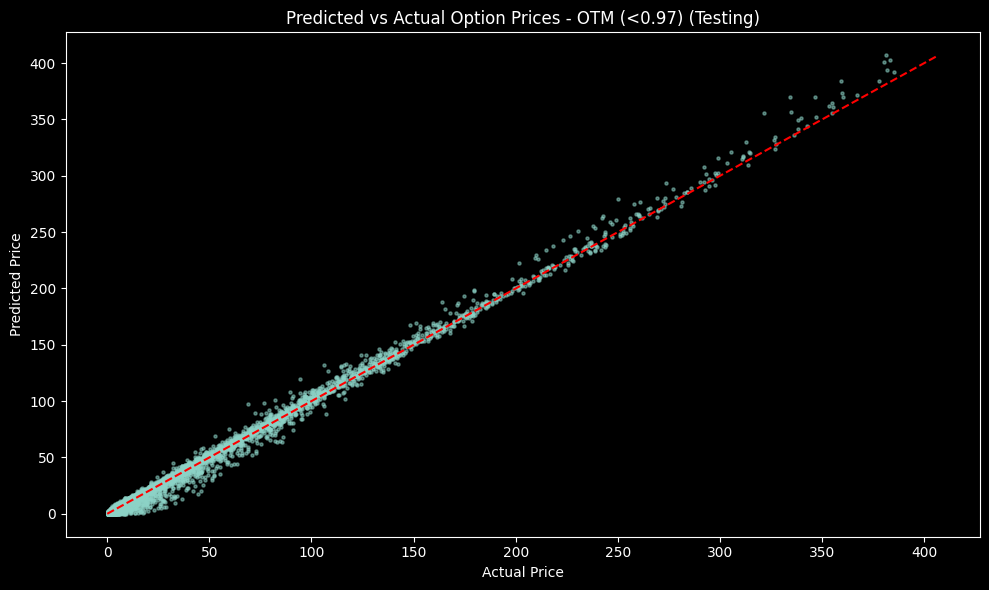

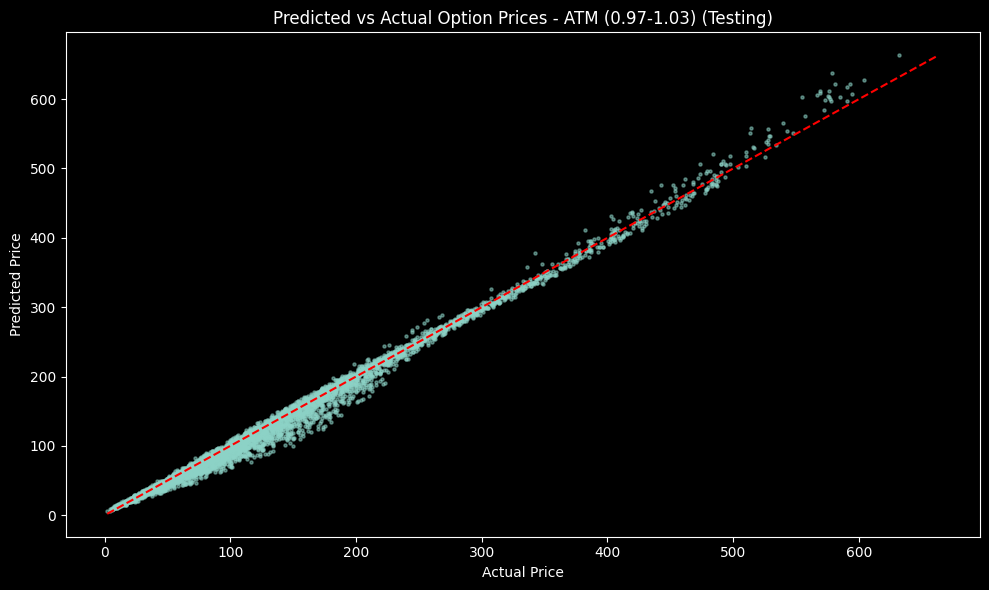

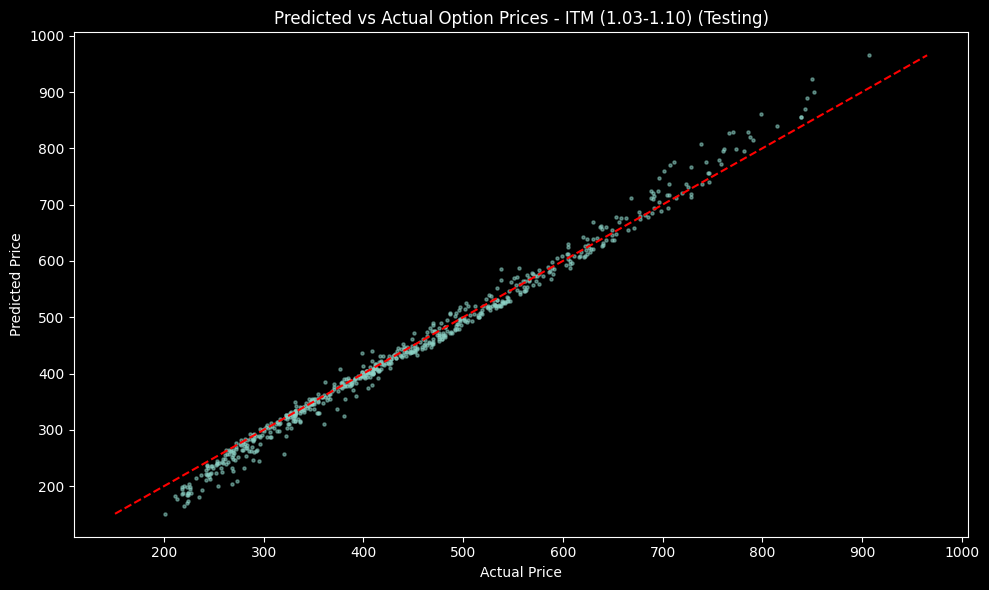

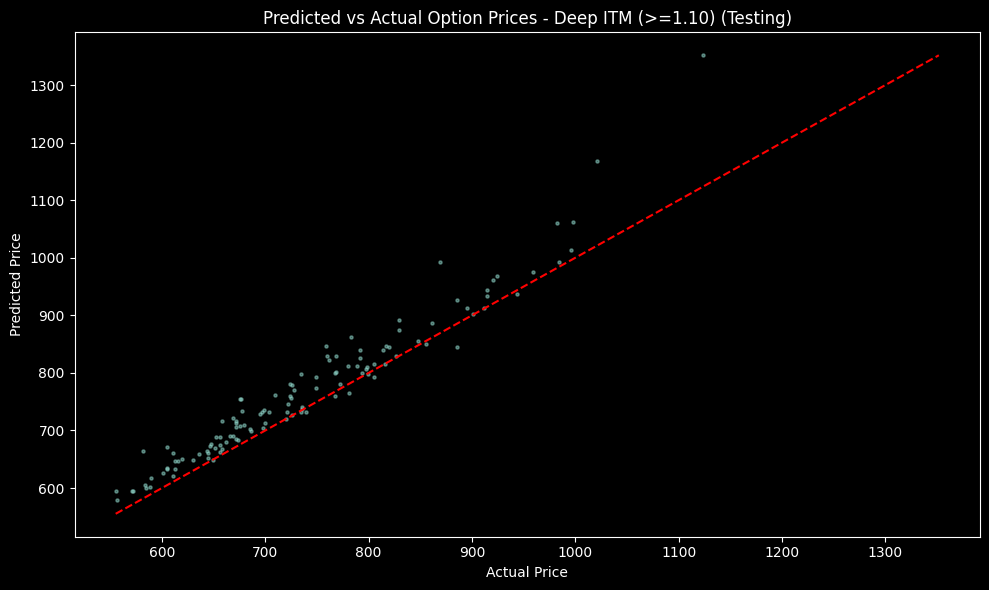

In [8]:
print("Collecting validation/testing price and Greek errors...")

import torchmetrics.functional as tmf
from scipy.optimize import brentq
from scipy.stats import norm

MONEYNESS_BINS = [0.0, 0.5, 0.90, 0.95, 1.05, 1.10, 1.15]
MONEYNESS_LABELS = [
    "DDOTM (0.00-0.50)",
    "DOTM (0.50-0.90)",
    "OTM (0.90-0.95)",
    "ATM (0.95-1.05)",
    "ITM (1.05-1.10)",
    "UITM (1.10-1.15)",
]
GREEK_NAMES = ["delta", "gamma", "theta", "vega"]


def compute_torchmetrics(real_values, model_values):
    real_values = np.asarray(real_values, dtype=np.float64)
    model_values = np.asarray(model_values, dtype=np.float64)
    finite = np.isfinite(real_values) & np.isfinite(model_values)

    if finite.sum() == 0:
        return {
            "mae": np.nan,
            "mse": np.nan,
            "rmse": np.nan,
            "mape_pct": np.nan,
            "smape_pct": np.nan,
            "r2": np.nan,
        }

    target = torch.tensor(real_values[finite], dtype=torch.float32)
    preds = torch.tensor(model_values[finite], dtype=torch.float32)

    mse = float(tmf.mean_squared_error(preds, target).item())
    metrics = {
        "mae": float(tmf.mean_absolute_error(preds, target).item()),
        "mse": mse,
        "rmse": float(np.sqrt(mse)),
        "mape_pct": float(tmf.mean_absolute_percentage_error(preds, target).item() * 100.0),
        "smape_pct": float(tmf.symmetric_mean_absolute_percentage_error(preds, target).item() * 100.0),
        "r2": float(tmf.r2_score(preds, target).item()) if target.numel() > 1 else np.nan,
    }
    return metrics


def summarize_errors(split_df, split_name):
    real_values = split_df.get_column("real_price").to_numpy()
    model_values = split_df.get_column("model_price").to_numpy()

    metrics = compute_torchmetrics(real_values, model_values)
    errors = split_df.get_column("error").to_numpy()

    print(
        f"{split_name}: n={len(errors):,}, mean={np.nanmean(errors):.4f}, std={np.nanstd(errors):.4f}, "
        f"MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, "
        f"MAPE={metrics['mape_pct']:.2f}%, SMAPE={metrics['smape_pct']:.2f}%, R2={metrics['r2']:.4f}"
    )
    return metrics


def bs_call_price(s, k, t, r, q, sigma):
    if not np.isfinite([s, k, t, r, q, sigma]).all():
        return np.nan
    if s <= 0 or k <= 0 or t <= 0 or sigma <= 0:
        return np.nan

    sqrt_t = np.sqrt(t)
    d1 = (np.log(s / k) + (r - q + 0.5 * sigma**2) * t) / (sigma * sqrt_t)
    d2 = d1 - sigma * sqrt_t
    return s * np.exp(-q * t) * norm.cdf(d1) - k * np.exp(-r * t) * norm.cdf(d2)


def bs_call_greeks(s, k, t, r, q, sigma):
    if not np.isfinite([s, k, t, r, q, sigma]).all():
        return np.nan, np.nan, np.nan, np.nan
    if s <= 0 or k <= 0 or t <= 0 or sigma <= 0:
        return np.nan, np.nan, np.nan, np.nan

    sqrt_t = np.sqrt(t)
    d1 = (np.log(s / k) + (r - q + 0.5 * sigma**2) * t) / (sigma * sqrt_t)
    d2 = d1 - sigma * sqrt_t

    pdf_d1 = norm.pdf(d1)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)

    delta = np.exp(-q * t) * cdf_d1
    gamma = (np.exp(-q * t) * pdf_d1) / (s * sigma * sqrt_t)
    theta = (
        -(s * np.exp(-q * t) * pdf_d1 * sigma) / (2.0 * sqrt_t)
        - r * k * np.exp(-r * t) * cdf_d2
        + q * s * np.exp(-q * t) * cdf_d1
    )
    vega = s * np.exp(-q * t) * pdf_d1 * sqrt_t
    return delta, gamma, theta, vega


def implied_vol_call_from_price(price, s, k, t, r, q, sigma_min=1e-6, sigma_max=5.0):
    if not np.isfinite([price, s, k, t, r, q]).all():
        return np.nan
    if s <= 0 or k <= 0 or t <= 0:
        return np.nan

    disc_q = np.exp(-q * t)
    disc_r = np.exp(-r * t)
    lower_bound = max(s * disc_q - k * disc_r, 0.0)
    upper_bound = s * disc_q

    # Clip observed market prices into no-arbitrage bounds to keep IV/Greek estimation stable.
    target = float(np.clip(price, lower_bound, upper_bound))

    def objective(sig):
        return bs_call_price(s, k, t, r, q, sig) - target

    f_low = objective(sigma_min)
    f_high = objective(sigma_max)

    if not np.isfinite(f_low) or not np.isfinite(f_high):
        return np.nan
    if abs(f_low) < 1e-10:
        return float(sigma_min)
    if abs(f_high) < 1e-10:
        return float(sigma_max)
    if f_low * f_high > 0:
        return np.nan

    try:
        return float(brentq(objective, sigma_min, sigma_max, xtol=1e-8, rtol=1e-8, maxiter=200))
    except Exception:
        return np.nan


def compute_bs_iv_and_greeks(real_prices, s_values, k_values, t_values, r_values, q_values):
    n = len(real_prices)
    implied_vol = np.full(n, np.nan, dtype=np.float64)
    bs_delta = np.full(n, np.nan, dtype=np.float64)
    bs_gamma = np.full(n, np.nan, dtype=np.float64)
    bs_theta = np.full(n, np.nan, dtype=np.float64)
    bs_vega = np.full(n, np.nan, dtype=np.float64)

    for i in range(n):
        sigma = implied_vol_call_from_price(
            price=real_prices[i],
            s=s_values[i],
            k=k_values[i],
            t=t_values[i],
            r=r_values[i],
            q=q_values[i],
        )
        implied_vol[i] = sigma

        if np.isfinite(sigma):
            delta, gamma, theta, vega = bs_call_greeks(
                s=s_values[i],
                k=k_values[i],
                t=t_values[i],
                r=r_values[i],
                q=q_values[i],
                sigma=sigma,
            )
            bs_delta[i] = delta
            bs_gamma[i] = gamma
            bs_theta[i] = theta
            bs_vega[i] = vega

    bs_greeks = {
        "delta": bs_delta,
        "gamma": bs_gamma,
        "theta": bs_theta,
        "vega": bs_vega,
    }
    return implied_vol, bs_greeks


def summarize_greek_errors(split_df, split_name):
    rows = []
    iv_values = split_df.get_column("implied_vol_real").to_numpy()
    iv_valid = int(np.isfinite(iv_values).sum())
    iv_pct = (100.0 * iv_valid / split_df.height) if split_df.height else 0.0

    print(f"{split_name}: implied-vol solved for {iv_valid:,}/{split_df.height:,} rows ({iv_pct:.2f}%)")

    for greek in GREEK_NAMES:
        actual_col = f"bs_{greek}"
        pred_col = f"model_{greek}"

        actual = split_df.get_column(actual_col).to_numpy().astype(np.float64)
        pred = split_df.get_column(pred_col).to_numpy().astype(np.float64)
        finite = np.isfinite(actual) & np.isfinite(pred)

        metrics = compute_torchmetrics(actual[finite], pred[finite]) if finite.any() else {
            "mae": np.nan,
            "mse": np.nan,
            "rmse": np.nan,
            "mape_pct": np.nan,
            "smape_pct": np.nan,
            "r2": np.nan,
        }

        rows.append(
            {
                "split": split_name,
                "greek": greek,
                "n_valid": int(finite.sum()),
                "mean_error": float(np.nanmean((pred - actual)[finite])) if finite.any() else np.nan,
                "std_error": float(np.nanstd((pred - actual)[finite])) if finite.any() else np.nan,
                **metrics,
            }
        )

    table = pl.DataFrame(rows)
    print(table)
    return table


def assign_moneyness_bucket(values):
    values = np.asarray(values, dtype=np.float64)
    buckets = np.array([None] * values.shape[0], dtype=object)

    for idx, label in enumerate(MONEYNESS_LABELS):
        lower = MONEYNESS_BINS[idx]
        upper = MONEYNESS_BINS[idx + 1]
        if idx == 0:
            mask = (values >= lower) & (values <= upper)
        else:
            mask = (values > lower) & (values <= upper)
        buckets[mask] = label

    return buckets


def collect_error_frame(loader, split_name):
    moneyness_parts = []
    s_parts = []
    k_parts = []
    t_years_parts = []
    t_days_parts = []
    dividend_parts = []
    rate_parts = []

    real_prices = []
    model_prices = []
    model_greek_parts = {name: [] for name in GREEK_NAMES}

    for batch in loader:
        query_x = batch["query_x"].to(device)
        query_y = batch["query_y"].to(device)
        query_mask = batch["query_mask"].to(device)
        context_x = batch["context_x"].to(device)
        context_y = batch["context_y"].to(device)
        context_mask = batch["context_mask"].to(device)

        with torch.no_grad():
            preds_norm, greeks = model(
                query_x=query_x,
                context_x=context_x,
                context_y=context_y,
                context_mask=context_mask,
            )

        valid_mask = query_mask.detach().cpu().numpy().reshape(-1).astype(bool)
        if not valid_mask.any():
            continue

        s = query_x[:, :, 0:1]
        k = query_x[:, :, 1:2]
        t_years = query_x[:, :, 2:3]
        t_days = t_years * 365.0
        dividend = query_x[:, :, 4:5]
        rate = query_x[:, :, 5:6]

        model_batch = (preds_norm * k).detach().cpu().numpy().reshape(-1)[valid_mask]
        real_batch = query_y.detach().cpu().numpy().reshape(-1)[valid_mask]

        model_prices.append(model_batch)
        real_prices.append(real_batch)

        s_parts.append(s.detach().cpu().numpy().reshape(-1)[valid_mask])
        k_parts.append(k.detach().cpu().numpy().reshape(-1)[valid_mask])
        t_years_parts.append(t_years.detach().cpu().numpy().reshape(-1)[valid_mask])
        t_days_parts.append(t_days.detach().cpu().numpy().reshape(-1)[valid_mask])
        dividend_parts.append(dividend.detach().cpu().numpy().reshape(-1)[valid_mask])
        rate_parts.append(rate.detach().cpu().numpy().reshape(-1)[valid_mask])

        moneyness_parts.append((s / k).detach().cpu().numpy().reshape(-1)[valid_mask])

        for greek in GREEK_NAMES:
            model_greek_parts[greek].append(
                greeks[greek].detach().cpu().numpy().reshape(-1)[valid_mask]
            )

    if not real_prices:
        raise ValueError(f"No rows available for {split_name} set.")

    real_prices = np.concatenate(real_prices)
    model_prices = np.concatenate(model_prices)

    s_values = np.concatenate(s_parts)
    k_values = np.concatenate(k_parts)
    t_years_values = np.concatenate(t_years_parts)
    t_days_values = np.concatenate(t_days_parts)
    dividend_values = np.concatenate(dividend_parts)
    rate_values = np.concatenate(rate_parts)
    moneyness = np.concatenate(moneyness_parts)

    r_values = np.where(np.isfinite(rate_values), rate_values, 0.0)
    q_values = np.where(np.isfinite(dividend_values), dividend_values, 0.0)

    implied_vol_real, bs_greeks = compute_bs_iv_and_greeks(
        real_prices=real_prices,
        s_values=s_values,
        k_values=k_values,
        t_values=t_years_values,
        r_values=r_values,
        q_values=q_values,
    )

    model_greeks = {
        greek: np.concatenate(parts) if parts else np.array([], dtype=np.float64)
        for greek, parts in model_greek_parts.items()
    }

    abs_error = np.abs(model_prices - real_prices)
    abs_pct_error = np.where(np.abs(real_prices) > 1e-8, (abs_error / np.abs(real_prices)) * 100.0, np.nan)

    frame = pl.DataFrame(
        {
            "split": split_name,
            "S": s_values,
            "K": k_values,
            "T_years": t_years_values,
            "T_days": t_days_values,
            "moneyness": moneyness,
            "risk_free_rate": r_values,
            "dividend_yield": q_values,
            "real_price": real_prices,
            "model_price": model_prices,
            "error": model_prices - real_prices,
            "abs_error": abs_error,
            "abs_pct_error": abs_pct_error,
            "difference": real_prices - model_prices,
            "implied_vol_real": implied_vol_real,
        }
    )

    extra_cols = []
    for greek in GREEK_NAMES:
        extra_cols.append(pl.Series(name=f"model_{greek}", values=model_greeks[greek]))
        extra_cols.append(pl.Series(name=f"bs_{greek}", values=bs_greeks[greek]))
    frame = frame.with_columns(extra_cols)

    frame = frame.with_columns(
        [
            (pl.col(f"model_{greek}") - pl.col(f"bs_{greek}")).alias(f"{greek}_error")
            for greek in GREEK_NAMES
        ]
    )

    frame = frame.with_columns(
        pl.Series(name="moneyness_bucket", values=assign_moneyness_bucket(moneyness))
    )

    split_metrics = summarize_errors(frame, split_name)
    greek_metrics = summarize_greek_errors(frame, split_name)
    return frame, split_metrics, greek_metrics


test_df, test_metrics, test_greek_metrics = collect_error_frame(data_module.test_dataloader(), "Testing")
all_errors = pl.concat([test_df], how="vertical_relaxed")

overall_metrics = compute_torchmetrics(
    all_errors.get_column("real_price").to_numpy(),
    all_errors.get_column("model_price").to_numpy(),
)

metrics_table = pl.DataFrame(
    [
        {
            "split": "Testing",
            "n": test_df.height,
            **test_metrics,
        },
        {
            "split": "Combined",
            "n": all_errors.height,
            **overall_metrics,
        },
    ]
)

print()
print("Torchmetrics summary (prices):")
print(metrics_table)

combined_greek_rows = []
for greek in GREEK_NAMES:
    actual = all_errors.get_column(f"bs_{greek}").to_numpy().astype(np.float64)
    pred = all_errors.get_column(f"model_{greek}").to_numpy().astype(np.float64)
    finite = np.isfinite(actual) & np.isfinite(pred)
    metrics = compute_torchmetrics(actual[finite], pred[finite]) if finite.any() else {
        "mae": np.nan,
        "mse": np.nan,
        "rmse": np.nan,
        "mape_pct": np.nan,
        "smape_pct": np.nan,
        "r2": np.nan,
    }
    combined_greek_rows.append(
        {
            "split": "Combined",
            "greek": greek,
            "n_valid": int(finite.sum()),
            "mean_error": float(np.nanmean((pred - actual)[finite])) if finite.any() else np.nan,
            "std_error": float(np.nanstd((pred - actual)[finite])) if finite.any() else np.nan,
            **metrics,
        }
    )

combined_greek_metrics = pl.DataFrame(combined_greek_rows)
greek_metrics_table = pl.concat(
    [test_greek_metrics, combined_greek_metrics],
    how="vertical_relaxed",
)

print()
print("Torchmetrics summary (Greeks vs Black-Scholes Greeks from real implied vol):")
print(greek_metrics_table)

surface_df = all_errors.select(["split", "K", "T_days", "difference", "moneyness"]).with_columns(
    pl.col("T_days").round(0).alias("T_days"),
    pl.col("moneyness").round(3).alias("moneyness"),
)

bucket_rows = []
for split_name, split_df in [ ("Testing", test_df)]:
    for bucket in MONEYNESS_LABELS:
        bucket_df = split_df.filter(pl.col("moneyness_bucket") == bucket)
        if bucket_df.is_empty():
            continue

        bucket_tm = compute_torchmetrics(
            bucket_df.get_column("real_price").to_numpy(),
            bucket_df.get_column("model_price").to_numpy(),
        )

        bucket_rows.append(
            {
                "split": split_name,
                "moneyness_bucket": bucket,
                "n": bucket_df.height,
                "mean_error": float(bucket_df.select(pl.col("error").mean()).item()),
                "std_error": float(bucket_df.select(pl.col("error").std()).item()),
                "mean_moneyness": float(bucket_df.select(pl.col("moneyness").mean()).item()),
                **bucket_tm,
            }
        )

bucket_metrics = pl.DataFrame(bucket_rows)
print()
print("Error metrics by moneyness bucket (prices):")
print(bucket_metrics)

fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=test_df.get_column("error").to_numpy(),
        name="Testing Error",
        opacity=0.65,
        histnorm="percent",
        nbinsx=80,
        marker_color="#ff7f0e",
    )
)
fig.add_vline(x=0.0, line_dash="dash", line_color="black")
fig.update_layout(
    title="Error Distribution: Model Price - Real Price (Validation vs Testing)",
    xaxis_title="Pricing Error",
    yaxis_title="Percent of Samples (%)",
    barmode="overlay",
    template="plotly_white",
    width=1000,
    height=500,
)
fig.show()

if not bucket_metrics.is_empty():
    mae_fig = go.Figure()
    for split_name, color in [("Validation", "#1f77b4"), ("Testing", "#ff7f0e")]:
        split_metrics = bucket_metrics.filter(pl.col("split") == split_name)
        if split_metrics.is_empty():
            continue
        mae_fig.add_trace(
            go.Bar(
                x=split_metrics.get_column("moneyness_bucket").to_list(),
                y=split_metrics.get_column("mae").to_numpy(),
                name=f"{split_name} MAE",
                marker_color=color,
                opacity=0.85,
            )
        )
    mae_fig.update_layout(
        title="MAE by Moneyness Bucket",
        xaxis_title="Moneyness Bucket",
        yaxis_title="MAE",
        barmode="group",
        template="plotly_white",
        width=1000,
        height=450,
    )
    mae_fig.show()

SCATTER_BUCKET_EDGES = [0.0, 0.97, 1.03, 1.10, np.inf]
SCATTER_BUCKET_LABELS = [
    "OTM (<0.97)",
    "ATM (0.97-1.03)",
    "ITM (1.03-1.10)",
    "Deep ITM (>=1.10)",
]
SCATTER_BUCKET_KEYS = ["otm", "atm", "itm", "deep_itm"]


def plot_bucketed_predicted_vs_actual(split_df, split_name):
    moneyness = split_df.get_column("moneyness").to_numpy()
    actual_all = split_df.get_column("real_price").to_numpy()
    predicted_all = split_df.get_column("model_price").to_numpy()

    for lower, upper, label, key in zip(
        SCATTER_BUCKET_EDGES[:-1],
        SCATTER_BUCKET_EDGES[1:],
        SCATTER_BUCKET_LABELS,
        SCATTER_BUCKET_KEYS,
    ):
        mask = (moneyness >= lower) & (moneyness < upper)
        if not mask.any():
            continue

        actual = actual_all[mask]
        predicted = predicted_all[mask]
        finite = np.isfinite(actual) & np.isfinite(predicted)
        actual = actual[finite]
        predicted = predicted[finite]

        if actual.size == 0:
            continue

        min_val = float(min(actual.min(), predicted.min()))
        max_val = float(max(actual.max(), predicted.max()))

        plt.figure(figsize=(10, 6))
        plt.scatter(actual, predicted, s=5, alpha=0.5)
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.title(f"Predicted vs Actual Option Prices - {label} ({split_name})")
        plt.tight_layout()

        plt.show()


for split_name, split_df in [("Testing", test_df)]:
    plot_bucketed_predicted_vs_actual(split_df, split_name)


In [ ]:
if "all_errors" not in globals():
    raise ValueError("all_errors is missing. Run the error collection cell first.")
if all_errors.is_empty():
    raise ValueError("all_errors is empty. Run the error collection cell first.")

from plotly.subplots import make_subplots

if "GREEK_NAMES" not in globals():
    GREEK_NAMES = ["delta", "gamma", "theta", "vega"]


def pivot_surface(frame, value_col):
    agg = (
        frame.group_by(["T_days", "moneyness"])
        .agg(pl.col(value_col).mean().alias(value_col))
        .sort(["T_days", "moneyness"])
    )

    if agg.is_empty():
        return None, None, None

    t_values = np.sort(agg.get_column("T_days").unique().to_numpy())
    m_values = np.sort(agg.get_column("moneyness").unique().to_numpy())
    z_grid = np.full((len(t_values), len(m_values)), np.nan, dtype=np.float64)

    t_index = {float(value): idx for idx, value in enumerate(t_values.tolist())}
    m_index = {float(value): idx for idx, value in enumerate(m_values.tolist())}

    for t_val, m_val, z_val in zip(
        agg.get_column("T_days").to_numpy(),
        agg.get_column("moneyness").to_numpy(),
        agg.get_column(value_col).to_numpy(),
    ):
        z_grid[t_index[float(t_val)], m_index[float(m_val)]] = float(z_val)

    return t_values, m_values, z_grid


def aligned_surfaces(frame, real_col, pred_col):
    surface_frame = frame.select(["T_days", "moneyness", real_col, pred_col]).with_columns(
        pl.col("T_days").round(0).alias("T_days"),
        pl.col("moneyness").round(3).alias("moneyness"),
    )

    real_t, real_m, real_surface = pivot_surface(surface_frame, real_col)
    pred_t, pred_m, pred_surface = pivot_surface(surface_frame, pred_col)

    if real_t is None or pred_t is None:
        return None, None, None, None, None

    common_t = np.intersect1d(real_t, pred_t)
    common_m = np.intersect1d(real_m, pred_m)

    if common_t.size == 0 or common_m.size == 0:
        return None, None, None, None, None

    real_t_index = {float(value): idx for idx, value in enumerate(real_t.tolist())}
    real_m_index = {float(value): idx for idx, value in enumerate(real_m.tolist())}
    pred_t_index = {float(value): idx for idx, value in enumerate(pred_t.tolist())}
    pred_m_index = {float(value): idx for idx, value in enumerate(pred_m.tolist())}

    real_t_pos = [real_t_index[float(value)] for value in common_t]
    real_m_pos = [real_m_index[float(value)] for value in common_m]
    pred_t_pos = [pred_t_index[float(value)] for value in common_t]
    pred_m_pos = [pred_m_index[float(value)] for value in common_m]

    aligned_real = real_surface[np.ix_(real_t_pos, real_m_pos)]
    aligned_pred = pred_surface[np.ix_(pred_t_pos, pred_m_pos)]
    error_surface = aligned_pred - aligned_real

    return common_t, common_m, aligned_real, aligned_pred, error_surface


def plot_surface_triplet(
    t_axis,
    m_axis,
    real_surface,
    pred_surface,
    error_surface,
    title,
    real_title,
    pred_title,
    error_title,
    z_title,
    error_z_title,
):
    fig = make_subplots(
        rows=1,
        cols=3,
        specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "surface"}]],
        subplot_titles=(real_title, pred_title, error_title),
        horizontal_spacing=0.01,
    )

    fig.add_trace(
        go.Surface(
            z=real_surface,
            x=m_axis,
            y=t_axis,
            colorscale="Blues",
            showscale=False,
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Surface(
            z=pred_surface,
            x=m_axis,
            y=t_axis,
            colorscale="Viridis",
            showscale=False,
        ),
        row=1,
        col=2,
    )
    fig.add_trace(
        go.Surface(
            z=error_surface,
            x=m_axis,
            y=t_axis,
            colorscale="RdBu",
            colorbar=dict(title=error_z_title, x=1.01, len=0.78, thickness=10),
            hovertemplate="Moneyness=%{x:.3f}<br>T(days)=%{y:.0f}<br>Error=%{z:.4f}<extra></extra>",
        ),
        row=1,
        col=3,
    )

    fig.update_layout(
        title=title,
        template="plotly_white",
        autosize=True,
        height=560,
        margin=dict(l=0, r=0, t=70, b=0),
        scene=dict(aspectmode="cube"),
        scene2=dict(aspectmode="cube"),
        scene3=dict(aspectmode="cube"),
    )

    fig.update_scenes(
        xaxis_title_text="Moneyness (S/K)",
        yaxis_title_text="Maturity (days)",
        zaxis_title_text=z_title,
        row=1,
        col=1,
    )
    fig.update_scenes(
        xaxis_title_text="Moneyness (S/K)",
        yaxis_title_text="Maturity (days)",
        zaxis_title_text=z_title,
        row=1,
        col=2,
    )
    fig.update_scenes(
        xaxis_title_text="Moneyness (S/K)",
        yaxis_title_text="Maturity (days)",
        zaxis_title_text=error_z_title,
        row=1,
        col=3,
    )

    fig.show(config={"responsive": True})


price_t, price_m, price_real, price_pred, price_error = aligned_surfaces(
    frame=all_errors,
    real_col="real_price",
    pred_col="model_price",
)

if price_t is None:
    raise ValueError("No overlapping grid points available for price surface comparison.")

plot_surface_triplet(
    t_axis=price_t,
    m_axis=price_m,
    real_surface=price_real,
    pred_surface=price_pred,
    error_surface=price_error,
    title="Option Price Surfaces: Real vs Predicted",
    real_title="Real Price Surface",
    pred_title="Predicted Price Surface",
    error_title="Price Error Surface",
    z_title="Price",
    error_z_title="Predicted - Real",
)

greek_title_map = {
    "delta": "Delta",
    "gamma": "Gamma",
    "theta": "Theta",
    "vega": "Vega",
}

for greek in GREEK_NAMES:
    real_col = f"bs_{greek}"
    pred_col = f"model_{greek}"

    valid_df = all_errors.select(["T_days", "moneyness", real_col, pred_col]).filter(
        pl.col(real_col).is_finite() & pl.col(pred_col).is_finite()
    )

    if valid_df.is_empty():
        print(f"Skipping {greek}: no finite rows after implied-vol/Greek calculation.")
        continue

    t_axis, m_axis, real_surface, pred_surface, error_surface = aligned_surfaces(
        frame=valid_df,
        real_col=real_col,
        pred_col=pred_col,
    )

    if t_axis is None:
        print(f"Skipping {greek}: no overlapping grid points for surface plotting.")
        continue

    greek_label = greek_title_map[greek]
    plot_surface_triplet(
        t_axis=t_axis,
        m_axis=m_axis,
        real_surface=real_surface,
        pred_surface=pred_surface,
        error_surface=error_surface,
        title=f"{greek_label} Surfaces: Black-Scholes (Real IV) vs Model",
        real_title=f"BS {greek_label}",
        pred_title=f"Model {greek_label}",
        error_title=f"{greek_label} Error",
        z_title=greek_label,
        error_z_title=f"Model - BS {greek_label}",
    )
